# Time Series Forecasting - Temperature

In this notebook we will create a model to forecast temperature and comment it, data cleaning and handling were made in the ETL notebook.

The purpose here is to implement a simple neural network using LSTM, GRU and CNN(1d), learn how to use it and compare performance.

### Justifying Architecture Choices

---

**Recurrent Neural Networks**

Recurrent Neural Networks (RNN) are designed to work with sequential data. Sequential data(can be time-series) can be in form of text, audio, video etc.
RNN uses the previous information in the sequence to produce the current output. 

But RNN's face short-term memory problem. It is caused due to vanishing gradient problem. As RNN processes more steps it suffers from vanishing gradient more than other neural network architectures.

The main problem is that it’s too difficult for RNN to learn to preserve information over many timesteps. In vanilla RNN the hidden state is constently being rewritten. For this problem there are two specialized versions of RNN:
- Long short-term memory (LSTM)
- Gated Recurrent Units (GRU)

The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.
 

**Long short-term memory (LSTM)**

- LSTM is a RNN architecture used in the field of deep learning. It can process not only single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition, speech recognition and anomaly detection in network traffic or IDSs (intrusion detection systems).

- LSTM networks are well-suited to classifying, processing and making predictions based on time series data.

- LSTM was proposed by Sepp Hochreiter and Jürgen Schmidhuber. Some reference articles can be found at this link related to Recurrent Neural Networks: https://people.idsia.ch//~juergen/rnn.html


**Gated Recurrent Units (GRU)**

- The GRU is like a long short-term memory (LSTM) with a forget gate, but has fewer parameters than LSTM.
- The workflow of GRU is same as RNN but the difference is in the operations inside the GRU unit.
- Introduced in 2014 by Kyunghyun Cho et al, GRU are a gating mechanism in recurrent neural networks. Link: [Kyunghyun Cho et al](https://arxiv.org/abs/1406.1078) (2014)



LSTM has three gates on the other hand GRU has only two gates. In LSTM they are the Input gate, Forget gate, and Output gate. Whereas in GRU we have a Reset gate and Update gate.

**Convolutional Neural Network (CNN)**

- In deep learning, a convolutional neural network (CNN) is a class of artificial neural networks, usually associated with Image-related tasks. But it is possible to use for 1-dimensional outputs and be used in time series.

- CNNs are regularized versions of multilayer perceptrons. Multilayer perceptrons usually mean fully connected networks but this makes them prone to overfitting data. But since this is a lighter structure, it costs less to process and takes less time to train. Everything will depend on the application, available resources and performance, so it must be seen on a case-by-case basis.

In this case, it will be tested for learning purposes.

In [63]:
!pip install -U scikit-learn

In [2]:
import zipfile
import urllib

import os
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Setting Seaborn Theme
sns.set_theme(style="whitegrid", font_scale=1.4)

plt.rcParams["figure.figsize"] = (15,9)

In [3]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

Here we will load preprocessed data ( cleaned and missing values handled)

In [4]:
# Reading cleaned dataframe
df = pd.read_csv('brasilia_temperature_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime',inplace=True,drop=True)
print(f"DataFrame Shape: {df.shape}")

# Getting a dataframe with only temperature
temperature_df = df['Temperature']

DataFrame Shape: (87672, 2)


First we will visualize data.

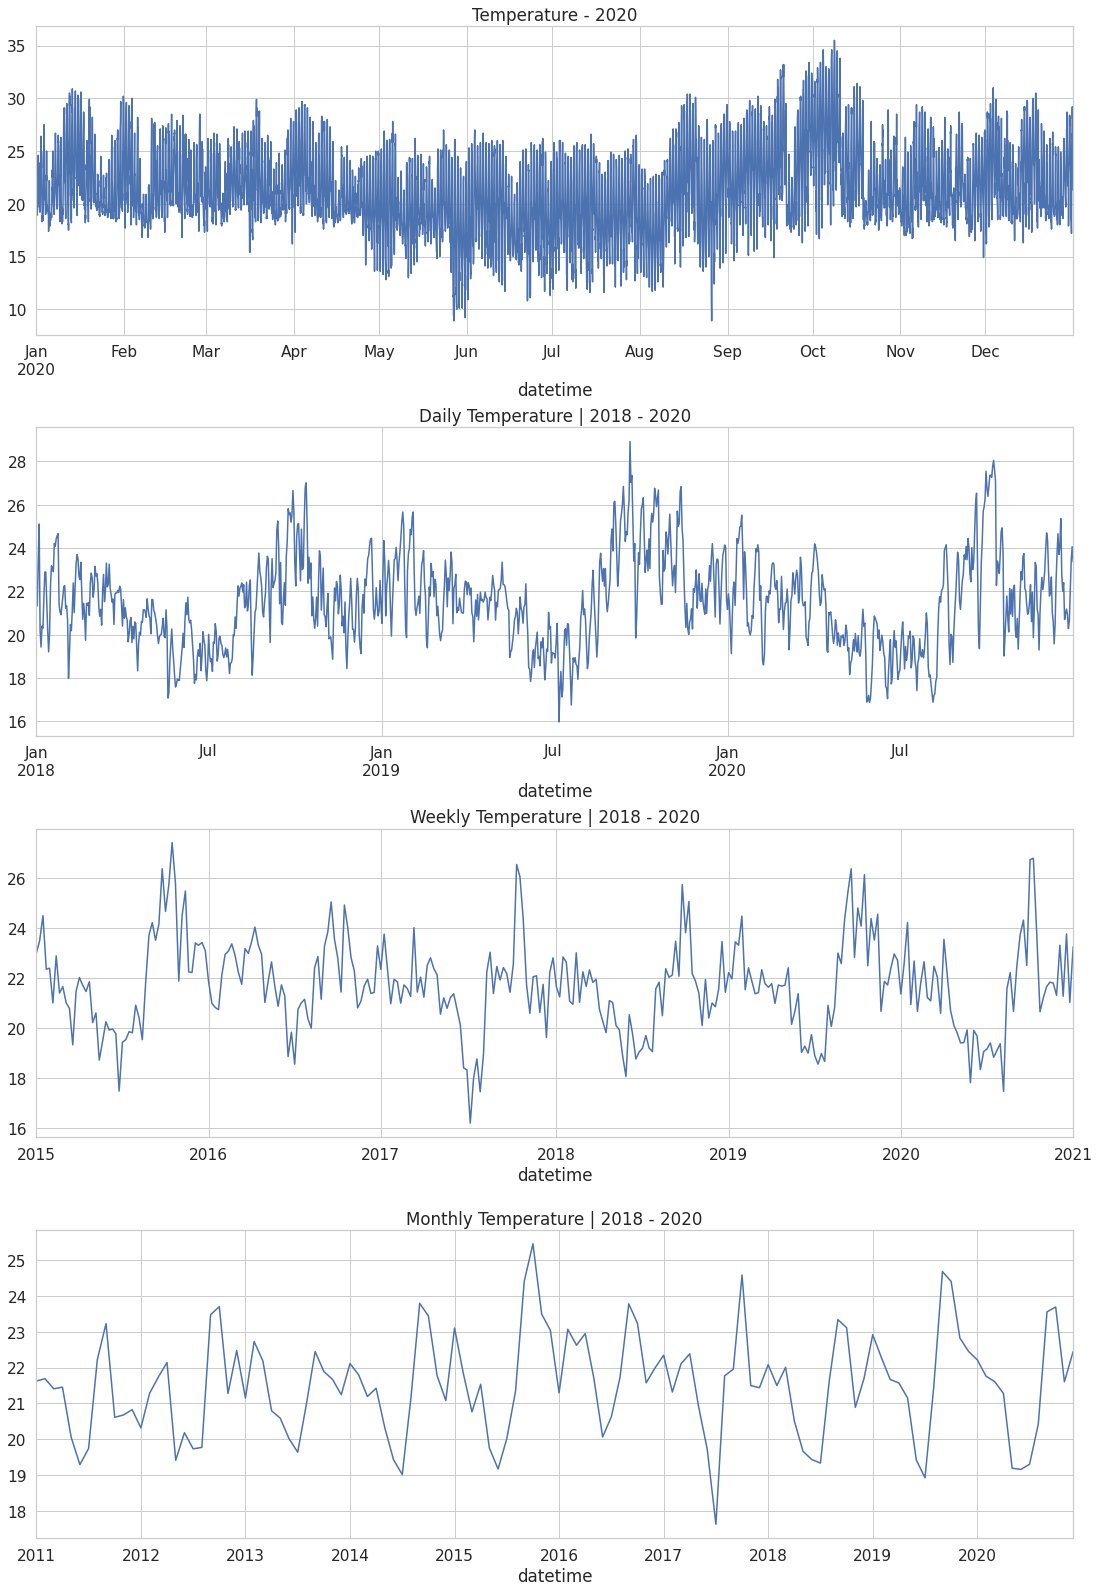

In [5]:
plt.rcParams["figure.figsize"] = (18,15)
fig1, axs = plt.subplots(nrows=4, ncols=1)

axs[0] = temperature_df['2020':].plot(ax = axs[0],title='Temperature - 2020')
axs[1] = temperature_df['2018':].resample('D').mean().plot(ax = axs[1], title='Daily Temperature | 2018 - 2020')
axs[2] = temperature_df['2015':].resample('W').mean().plot(ax = axs[2], title='Weekly Temperature | 2018 - 2020')
axs[3] = temperature_df['2011':].resample('M').mean().plot(ax = axs[3], title='Monthly Temperature | 2018 - 2020')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.1, 
                    hspace=0.3)

plt.show()

Here we can see that temperature have some seasonality, so we can take advantage of this pattern at some point in this notebook.

## First Model - Temperature and Sliding Window.

---

We were using only 2018 to 2020 data but we can see some sort of seasonality , which is good to use prophet, but lets see how it will behave with LSTM. Initially, without considering time itself and periodicity.

In this LSTM/GRU/CNN it will be used sliding windows as input, default will be using the last 5 hours to predict the next hour.

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

def train_test_val_split(df, window_size=5):
    X, y = df_to_X_y(df, window_size)

    total_len = len(X)
    test_val_len = int(total_len * 0.10)
    train_len = total_len - (2*test_val_len)

    X_train, y_train = X[:train_len], y[:train_len]
    X_val, y_val = X[train_len:train_len + test_val_len], y[train_len:train_len + test_val_len]
    X_test, y_test = X[train_len + test_val_len:], y[train_len + test_val_len:]

    print("_"*40)
    print("    OUTPUT SHAPE\n")
    print(f" X train: {X_train.shape}\n y train: {y_train.shape}\n\n X val: {X_val.shape}\n y val: {y_val.shape}\n\n X test: {X_test.shape}\n y test:{y_test.shape}")
    print("_"*40)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_val_split(temperature_df, 5)

________________________________________
    OUTPUT SHAPE

 X train: (70135, 5, 1)
 y train: (70135,)

 X val: (8766, 5, 1)
 y val: (8766,)

 X test: (8766, 5, 1)
 y test:(8766,)
________________________________________


In [51]:
def train_model_LSTM(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001, input_layer=(5,1)):

    model = Sequential()
    model.add(InputLayer(input_layer))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    cp1 = ModelCheckpoint(f'{model_name}/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(),MeanAbsolutePercentageError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp1])

    return model

def train_model_conv1d(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001, input_layer=(5,1)):
    model = Sequential()
    model.add(InputLayer(input_layer))
    model.add(Conv1D(64, kernel_size=2))
    model.add(Flatten())
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))


    cp = ModelCheckpoint(f'{model_name}/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError(),MeanAbsolutePercentageError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp])

    return model

def train_model_GRU(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001, input_layer=(5,1)):
    model = Sequential()
    model.add(InputLayer(input_layer))
    model.add(GRU(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    cp3 = ModelCheckpoint(f'{model_name}/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError(),MeanAbsolutePercentageError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp3])

    return model

In [9]:
def show_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name='LSTM'):
    print("_"*100)
    print(f"{model_name} Model".center(100, ' '))
    
    

    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
    print('\n\n')
    print("_"*100)
    print(f"{model_name} Model - TRAIN DATA".center(100, ' '))
    print('\n')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_train,train_predictions)*100,2)}%')
    print('\n')
    print(train_results)
    train_results[:100].plot()
    plt.show()
    
    val_predictions = model.predict(X_val).flatten()
    val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
    print('\n\n')
    print("_"*100)
    print(f"{model_name} Model - VALIDATION DATA".center(100, ' '))
    print('\n')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_val,val_predictions)*100,2)}%')
    print('\n')
    print(val_results);
    val_results[:100].plot()
    plt.show()
    
    test_predictions = model.predict(X_test).flatten()
    test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
    print('\n\n')
    print("_"*100)
    print(f"{model_name} Model - TEST DATA".center(100, ' '))
    print('\n')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_test,test_predictions)*100,2)}%')
    print('\n')
    print(test_results)
    test_results[:100].plot()
    plt.show()

### Model - LSTM
---

In [10]:
%%time
model_LSTM = train_model_LSTM(X_train, y_train, X_val, y_val, 'model_LSTM', epochs=10, learning_rate=0.0001)

Epoch 1/10
2192/2192 [==============================] - 24s 9ms/step - loss: 67.6193 - root_mean_squared_error: 8.2231 - mean_absolute_percentage_error: 26.1147 - val_loss: 6.7959 - val_root_mean_squared_error: 2.6069 - val_mean_absolute_percentage_error: 8.9935


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 2/10
2192/2192 [==============================] - 10s 4ms/step - loss: 2.3432 - root_mean_squared_error: 1.5307 - mean_absolute_percentage_error: 5.2726 - val_loss: 1.6490 - val_root_mean_squared_error: 1.2841 - val_mean_absolute_percentage_error: 4.2609


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 3/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.2761 - root_mean_squared_error: 1.1297 - mean_absolute_percentage_error: 3.7900 - val_loss: 1.4237 - val_root_mean_squared_error: 1.1932 - val_mean_absolute_percentage_error: 3.8985


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 4/10
2192/2192 [==============================] - 10s 4ms/step - loss: 1.2050 - root_mean_squared_error: 1.0977 - mean_absolute_percentage_error: 3.6653 - val_loss: 1.3808 - val_root_mean_squared_error: 1.1751 - val_mean_absolute_percentage_error: 3.8175


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 5/10
2192/2192 [==============================] - 10s 4ms/step - loss: 1.1875 - root_mean_squared_error: 1.0897 - mean_absolute_percentage_error: 3.6324 - val_loss: 1.3692 - val_root_mean_squared_error: 1.1701 - val_mean_absolute_percentage_error: 3.8063


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 6/10
2192/2192 [==============================] - 10s 4ms/step - loss: 1.1787 - root_mean_squared_error: 1.0857 - mean_absolute_percentage_error: 3.6196 - val_loss: 1.3510 - val_root_mean_squared_error: 1.1623 - val_mean_absolute_percentage_error: 3.8355


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 7/10
2192/2192 [==============================] - 10s 4ms/step - loss: 1.1723 - root_mean_squared_error: 1.0827 - mean_absolute_percentage_error: 3.6043 - val_loss: 1.3638 - val_root_mean_squared_error: 1.1678 - val_mean_absolute_percentage_error: 3.7542
Epoch 8/10
2192/2192 [==============================] - 10s 4ms/step - loss: 1.1651 - root_mean_squared_error: 1.0794 - mean_absolute_percentage_error: 3.5919 - val_loss: 1.3399 - val_root_mean_squared_error: 1.1575 - val_mean_absolute_percentage_error: 3.7749


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 9/10
2192/2192 [==============================] - 13s 6ms/step - loss: 1.1621 - root_mean_squared_error: 1.0780 - mean_absolute_percentage_error: 3.5789 - val_loss: 1.3365 - val_root_mean_squared_error: 1.1561 - val_mean_absolute_percentage_error: 3.7796


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 10/10
2192/2192 [==============================] - 10s 4ms/step - loss: 1.1566 - root_mean_squared_error: 1.0754 - mean_absolute_percentage_error: 3.5705 - val_loss: 1.3286 - val_root_mean_squared_error: 1.1526 - val_mean_absolute_percentage_error: 3.7710


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


CPU times: user 3min 11s, sys: 7.78 s, total: 3min 19s
Wall time: 3min 27s


In [60]:
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


____________________________________________________________________________________________________
                                             LSTM Model                                             



____________________________________________________________________________________________________
                                      LSTM Model - TRAIN DATA                                       


MAPE: 3.6%


       Train Predictions  Actuals
0              17.774128     18.2
1              18.481722     17.8
2              18.069553     18.0
3              18.431522     17.9
4              18.290003     17.9
...                  ...      ...
70130          18.596556     18.2
70131          18.615616     18.4
70132          18.879738     18.0
70133          18.322067     18.7
70134          19.224428     19.0

[70135 rows x 2 columns]


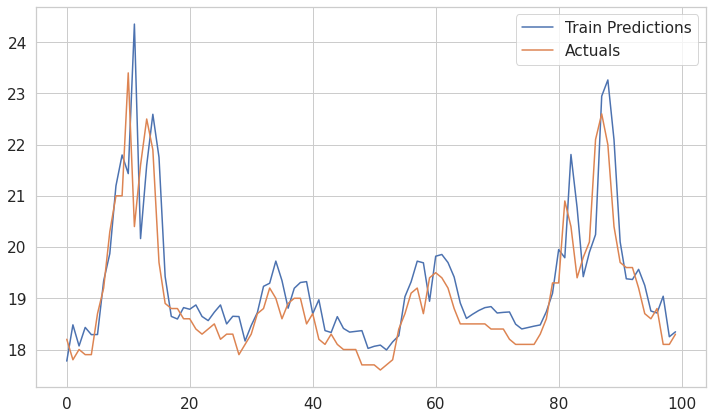




____________________________________________________________________________________________________
                                    LSTM Model - VALIDATION DATA                                    


MAPE: 3.77%


      Val Predictions  Actuals
0           19.526327     19.6
1           20.234591     22.2
2           23.534067     24.2
3           25.532513     24.8
4           25.592041     23.4
...               ...      ...
8761        23.415462     24.0
8762        25.039301     22.8
8763        22.845219     21.6
8764        21.234865     24.6
8765        24.807695     24.5

[8766 rows x 2 columns]


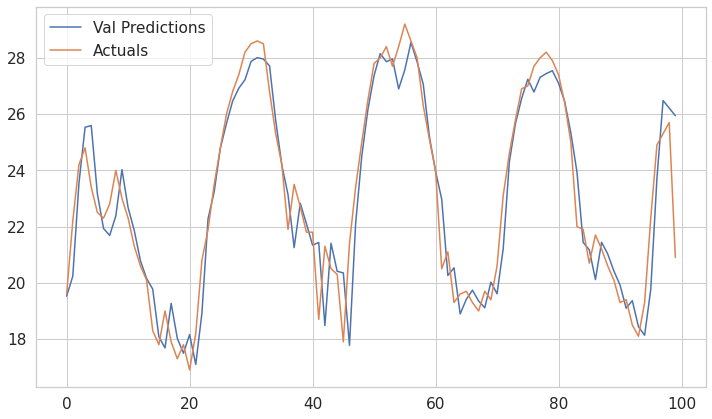




____________________________________________________________________________________________________
                                       LSTM Model - TEST DATA                                       


MAPE: 3.79%


      Test Predictions  Actuals
0            24.394405     20.0
1            19.823042     22.3
2            22.020699     23.9
3            23.882872     23.9
4            23.956512     21.7
...                ...      ...
8761         27.212954     28.1
8762         27.127502     23.6
8763         23.045898     23.6
8764         22.580252     22.3
8765         21.458443     21.3

[8766 rows x 2 columns]


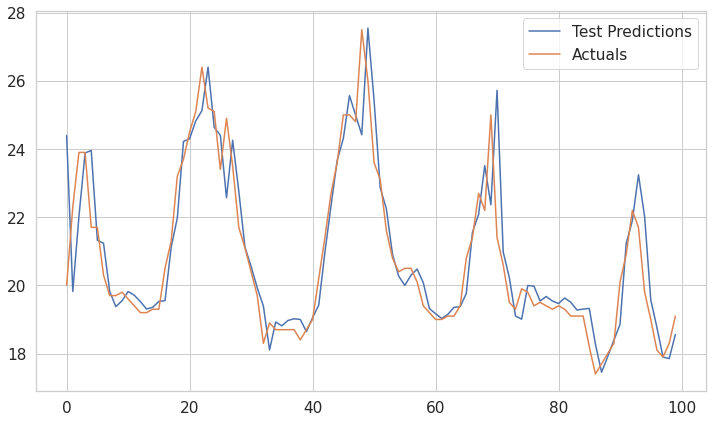

In [11]:
plt.rcParams["figure.figsize"] = (12,7)
show_model(model_LSTM, X_train, y_train, X_val, y_val, X_test, y_test)

### Model - GRU
---

In [12]:
%%time
model_GRU = train_model_GRU(X_train, y_train, X_val, y_val, 'model_GRU', epochs=10, learning_rate=0.0001)

Epoch 1/10
2192/2192 [==============================] - 12s 5ms/step - loss: 102.1651 - root_mean_squared_error: 10.1077 - mean_absolute_percentage_error: 34.9253 - val_loss: 9.8114 - val_root_mean_squared_error: 3.1323 - val_mean_absolute_percentage_error: 9.6701


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 2/10
2192/2192 [==============================] - 10s 5ms/step - loss: 3.0011 - root_mean_squared_error: 1.7324 - mean_absolute_percentage_error: 5.4214 - val_loss: 1.8783 - val_root_mean_squared_error: 1.3705 - val_mean_absolute_percentage_error: 4.3376


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 3/10
2192/2192 [==============================] - 10s 5ms/step - loss: 1.3211 - root_mean_squared_error: 1.1494 - mean_absolute_percentage_error: 3.7912 - val_loss: 1.4487 - val_root_mean_squared_error: 1.2036 - val_mean_absolute_percentage_error: 3.9324


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 4/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.1977 - root_mean_squared_error: 1.0944 - mean_absolute_percentage_error: 3.6277 - val_loss: 1.3676 - val_root_mean_squared_error: 1.1695 - val_mean_absolute_percentage_error: 3.8377


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 5/10
2192/2192 [==============================] - 10s 5ms/step - loss: 1.1675 - root_mean_squared_error: 1.0805 - mean_absolute_percentage_error: 3.5769 - val_loss: 1.3396 - val_root_mean_squared_error: 1.1574 - val_mean_absolute_percentage_error: 3.7713


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 6/10
2192/2192 [==============================] - 10s 5ms/step - loss: 1.1538 - root_mean_squared_error: 1.0741 - mean_absolute_percentage_error: 3.5540 - val_loss: 1.3298 - val_root_mean_squared_error: 1.1532 - val_mean_absolute_percentage_error: 3.7126


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 7/10
2192/2192 [==============================] - 10s 4ms/step - loss: 1.1471 - root_mean_squared_error: 1.0710 - mean_absolute_percentage_error: 3.5442 - val_loss: 1.3580 - val_root_mean_squared_error: 1.1653 - val_mean_absolute_percentage_error: 3.7587
Epoch 8/10
2192/2192 [==============================] - 10s 4ms/step - loss: 1.1421 - root_mean_squared_error: 1.0687 - mean_absolute_percentage_error: 3.5303 - val_loss: 1.3164 - val_root_mean_squared_error: 1.1473 - val_mean_absolute_percentage_error: 3.7157


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 9/10
2192/2192 [==============================] - 10s 4ms/step - loss: 1.1384 - root_mean_squared_error: 1.0670 - mean_absolute_percentage_error: 3.5245 - val_loss: 1.3254 - val_root_mean_squared_error: 1.1513 - val_mean_absolute_percentage_error: 3.7284
Epoch 10/10
2192/2192 [==============================] - 10s 4ms/step - loss: 1.1351 - root_mean_squared_error: 1.0654 - mean_absolute_percentage_error: 3.5172 - val_loss: 1.3170 - val_root_mean_squared_error: 1.1476 - val_mean_absolute_percentage_error: 3.6981
CPU times: user 2min 53s, sys: 7.85 s, total: 3min 1s
Wall time: 2min 13s


In [61]:
model_GRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


____________________________________________________________________________________________________
                                             GRU Model                                              



____________________________________________________________________________________________________
                                       GRU Model - TRAIN DATA                                       


MAPE: 3.49%


       Train Predictions  Actuals
0              17.534761     18.2
1              18.464981     17.8
2              17.911398     18.0
3              18.268530     17.9
4              18.141190     17.9
...                  ...      ...
70130          18.538273     18.2
70131          18.494425     18.4
70132          18.761719     18.0
70133          18.119856     18.7
70134          19.199038     19.0

[70135 rows x 2 columns]


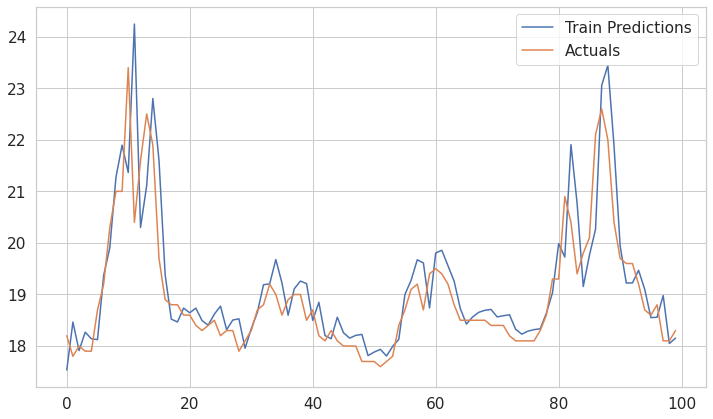




____________________________________________________________________________________________________
                                    GRU Model - VALIDATION DATA                                     


MAPE: 3.7%


      Val Predictions  Actuals
0           19.537115     19.6
1           20.238756     22.2
2           23.487888     24.2
3           25.354897     24.8
4           25.626457     23.4
...               ...      ...
8761        23.474089     24.0
8762        24.973700     22.8
8763        22.826496     21.6
8764        20.927240     24.6
8765        24.701487     24.5

[8766 rows x 2 columns]


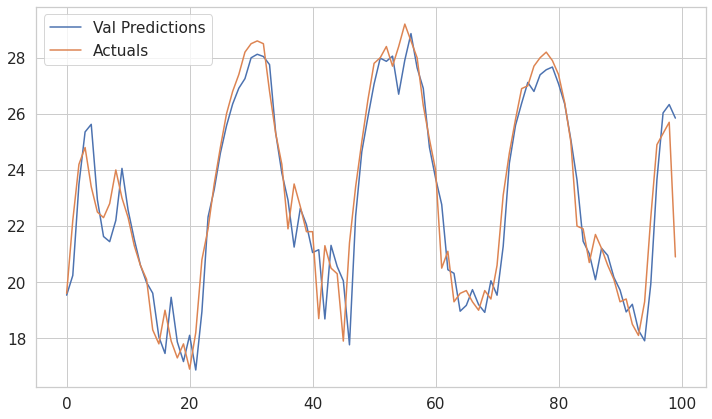




____________________________________________________________________________________________________
                                       GRU Model - TEST DATA                                        


MAPE: 3.66%


      Test Predictions  Actuals
0            24.774181     20.0
1            20.078314     22.3
2            21.528782     23.9
3            24.259348     23.9
4            24.020744     21.7
...                ...      ...
8761         27.332190     28.1
8762         27.252541     23.6
8763         22.936346     23.6
8764         22.387495     22.3
8765         21.417988     21.3

[8766 rows x 2 columns]


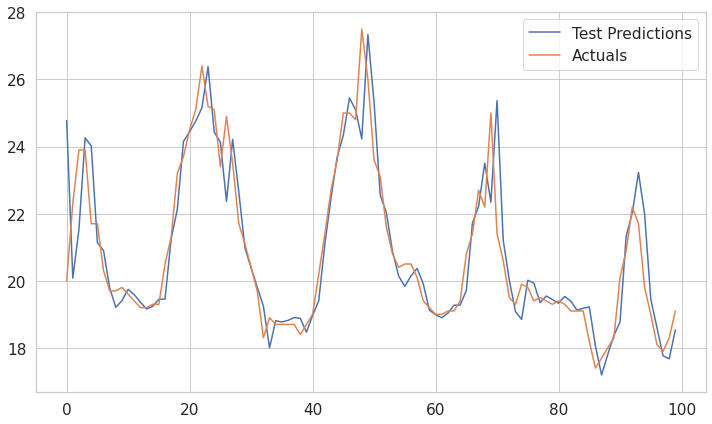

In [13]:
show_model(model_GRU, X_train, y_train, X_val, y_val, X_test, y_test, model_name='GRU')

### Model - Conv 1d
---

In [14]:
%%time
model_conv1d = train_model_conv1d(X_train, y_train, X_val, y_val, 'model_conv1d', epochs=10, learning_rate=0.0001)

Epoch 1/10
2192/2192 [==============================] - 5s 2ms/step - loss: 474.2388 - root_mean_squared_error: 21.7770 - mean_absolute_percentage_error: 99.8603 - val_loss: 489.1013 - val_root_mean_squared_error: 22.1156 - val_mean_absolute_percentage_error: 98.9809
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 2/10
2192/2192 [==============================] - 3s 2ms/step - loss: 461.2731 - root_mean_squared_error: 21.4773 - mean_absolute_percentage_error: 98.4353 - val_loss: 479.6564 - val_root_mean_squared_error: 21.9011 - val_mean_absolute_percentage_error: 97.9545
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 3/10
2192/2192 [==============================] - 3s 2ms/step - loss: 452.0952 - root_mean_squared_error: 21.2625 - mean_absolute_percentage_error: 97.3875 - val_loss: 470.3079 - val_root_mean_squared_error: 21.6866 - val_mean_absolute_percentage_error: 96.9281
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 4/10
2192/2192 [==============================] - 3s 2ms/step - loss: 443.0180 - root_mean_squared_error: 21.0480 - mean_absolute_percentage_error: 96.3389 - val_loss: 461.0579 - val_root_mean_squared_error: 21.4723 - val_mean_absolute_percentage_error: 95.9023
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 5/10
2192/2192 [==============================] - 3s 2ms/step - loss: 434.0322 - root_mean_squared_error: 20.8334 - mean_absolute_percentage_error: 95.2921 - val_loss: 451.8985 - val_root_mean_squared_error: 21.2579 - val_mean_absolute_percentage_error: 94.8758
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 6/10
2192/2192 [==============================] - 3s 2ms/step - loss: 425.1447 - root_mean_squared_error: 20.6190 - mean_absolute_percentage_error: 94.2437 - val_loss: 442.8396 - val_root_mean_squared_error: 21.0438 - val_mean_absolute_percentage_error: 93.8500
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 7/10
2192/2192 [==============================] - 3s 2ms/step - loss: 416.3551 - root_mean_squared_error: 20.4048 - mean_absolute_percentage_error: 93.1954 - val_loss: 433.8782 - val_root_mean_squared_error: 20.8297 - val_mean_absolute_percentage_error: 92.8245
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 8/10
2192/2192 [==============================] - 3s 2ms/step - loss: 407.6593 - root_mean_squared_error: 20.1906 - mean_absolute_percentage_error: 92.1481 - val_loss: 425.0083 - val_root_mean_squared_error: 20.6157 - val_mean_absolute_percentage_error: 91.7985
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 9/10
2192/2192 [==============================] - 3s 2ms/step - loss: 399.0582 - root_mean_squared_error: 19.9764 - mean_absolute_percentage_error: 91.1008 - val_loss: 416.2335 - val_root_mean_squared_error: 20.4018 - val_mean_absolute_percentage_error: 90.7726
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 10/10
2192/2192 [==============================] - 3s 2ms/step - loss: 390.5525 - root_mean_squared_error: 19.7624 - mean_absolute_percentage_error: 90.0532 - val_loss: 407.5559 - val_root_mean_squared_error: 20.1880 - val_mean_absolute_percentage_error: 89.7470
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


CPU times: user 48.7 s, sys: 3.62 s, total: 52.4 s
Wall time: 1min 22s


In [62]:
model_conv1d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 64)             192       
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


____________________________________________________________________________________________________
                                           Conv 1d Model                                            



____________________________________________________________________________________________________
                                     Conv 1d Model - TRAIN DATA                                     


MAPE: 89.53%


       Train Predictions  Actuals
0               2.178874     18.2
1               2.178874     17.8
2               2.178874     18.0
3               2.178874     17.9
4               2.178874     17.9
...                  ...      ...
70130           2.178874     18.2
70131           2.178874     18.4
70132           2.178874     18.0
70133           2.178874     18.7
70134           2.178874     19.0

[70135 rows x 2 columns]


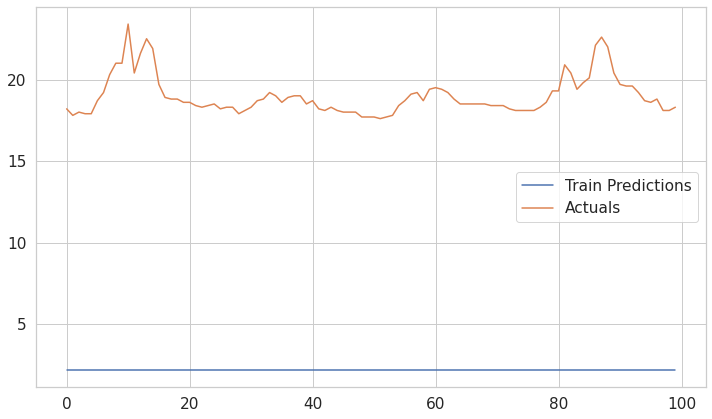




____________________________________________________________________________________________________
                                  Conv 1d Model - VALIDATION DATA                                   


MAPE: 89.75%


      Val Predictions  Actuals
0            2.178874     19.6
1            2.178874     22.2
2            2.178874     24.2
3            2.178874     24.8
4            2.178874     23.4
...               ...      ...
8761         2.178874     24.0
8762         2.178874     22.8
8763         2.178874     21.6
8764         2.178874     24.6
8765         2.178874     24.5

[8766 rows x 2 columns]


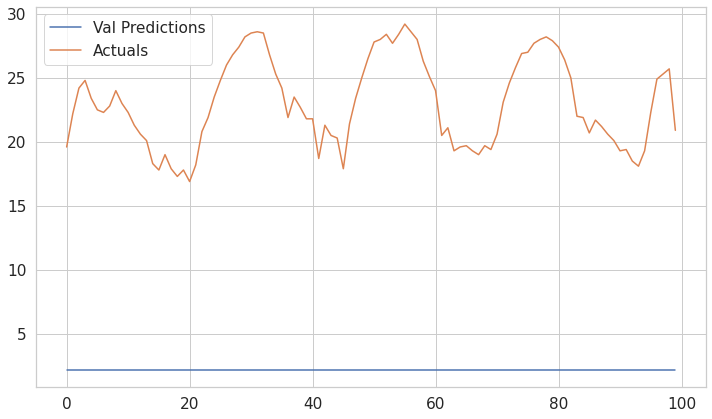




____________________________________________________________________________________________________
                                     Conv 1d Model - TEST DATA                                      


MAPE: 89.43%


      Test Predictions  Actuals
0             2.178874     20.0
1             2.178874     22.3
2             2.178874     23.9
3             2.178874     23.9
4             2.178874     21.7
...                ...      ...
8761          2.178874     28.1
8762          2.178874     23.6
8763          2.178874     23.6
8764          2.178874     22.3
8765          2.178874     21.3

[8766 rows x 2 columns]


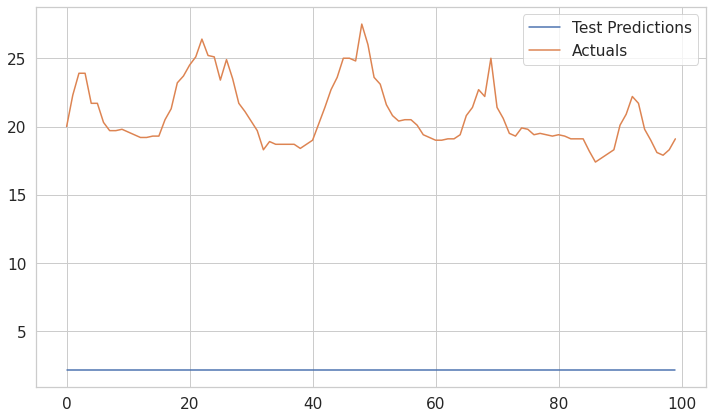

In [15]:
show_model(model_conv1d, X_train, y_train, X_val, y_val, X_test, y_test, model_name='Conv 1d')

## Second Model - Temperature, Time and Sliding Window

---

Some data is inherently cyclical. Time is a rich example of this: 
- Minutes; 
- Hours;
- Seconds;
- Day of the Week;
- Week of the Month;
- Month; 
- Season;

and so on all follow cycles.

---

We have already noted at the beginning of this notebook that our data have seasonality, meaning that this data is cyclical.

The thought behind it is not really an out-of-the-box idea, because usually during the day is hotter than in the middle of the night and during winter we have lower temperatures than in the summer. All of this can be fit in a 24 hours a day cycle and in a 365.2425 days a year cycle.

So this second model will try to use this information.

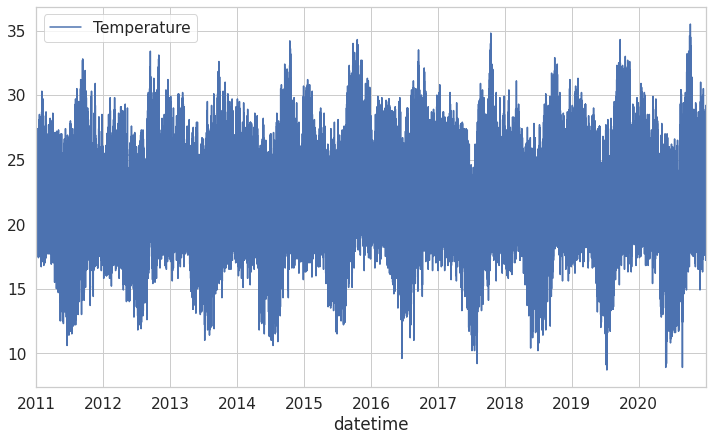

In [16]:
temp_df = pd.DataFrame({'Temperature':temperature_df})
temp_df.plot();

It is a noisy plot ( No need to plot all grouped plots again), but we can notice a cyclical pattern.

So the first step is to transform DateTime data into useful information.

When we are dealing with time-series data, it is also common that our dataframe's index has a DateTime format (YYYY-MM-DD HH:MM:SS) and it is true in our case too, because of that we will not extract much information from it, except the ascending order of data points. But there might be some hidden patterns in your dataset that will not be revealed by the regular features, so first we will need to transform them into timestamps

A ***timestamp*** basically represents a single instant, a specific point on the timeline, and its value corresponds to a certain amount of time elapsed from an initial instant. In our case, it is represented in seconds and will require some transformations to get it in a useful format.

In [17]:
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Temperature,Seconds
datetime,,
2011-01-01 00:00:00,19.2,1.293840e+09
2011-01-01 01:00:00,19.3,1.293844e+09
2011-01-01 02:00:00,19.1,1.293847e+09
2011-01-01 03:00:00,18.1,1.293851e+09
2011-01-01 04:00:00,17.7,1.293854e+09
...,...,...
2020-12-31 19:00:00,28.1,1.609441e+09
2020-12-31 20:00:00,23.6,1.609445e+09
2020-12-31 21:00:00,23.6,1.609448e+09


Now to extract information from the timestamps we need to get cyclical behavior from this, since we know that a day have 24 hours and a year have 365.2425 days, we can make an abstraction using Sin and Cosine in order to get cyclical behavior.

For example:  Cosine varies between -1 and 1 according to a 0–2π cycle.

<p align="center"><img src="https://www.math.hkust.edu.hk/~machiang/1013/Notes/cosine_2.gif" height="300px"></p>

It looks all set and done, but there is a catch:

As we can see in the gif above, at some point we will have diferent times with the same cosine, which will give our models the wrong idea that this 2 different hours are the same.

So we probably need to add another cyclical information in order to distinguish these two times with identical cosine values.

We could think of it as a two-axis coordinates system.

To solve this, we will use Sin and you can check it bellow:

<p align="center"><img src="https://www.math.hkust.edu.hk/~machiang/1013/Notes/sine_2.gif" height="300px"></p>

Combining Sin and Cosine we will have an unique coordinate for hours and year. Now we will transform our 'Seconds' using Sin and Cos.

In [18]:
# Getting Seconds in a Day
day = 60*60*24

# Getting Seconds in a Year
year = 365.2425*day

# Creating features out of sin and cos
temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

,Temperature,Seconds,Day sin,Day cos,Year sin,Year cos
datetime,,,,,,
2011-01-01 00:00:00,19.2,1.293840e+09,-7.057106e-12,1.000000,0.000989,1.000000
2011-01-01 01:00:00,19.3,1.293844e+09,2.588190e-01,0.965926,0.001706,0.999999
2011-01-01 02:00:00,19.1,1.293847e+09,5.000000e-01,0.866025,0.002423,0.999997
2011-01-01 03:00:00,18.1,1.293851e+09,7.071068e-01,0.707107,0.003140,0.999995
2011-01-01 04:00:00,17.7,1.293854e+09,8.660254e-01,0.500000,0.003856,0.999993


Drop **Seconds** column since it is continuous and it will not add any information to the model.

In [19]:
temp_df = temp_df.drop('Seconds', axis=1)
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
datetime,,,,,
2011-01-01 00:00:00,19.2,-7.057106e-12,1.000000,0.000989,1.000000
2011-01-01 01:00:00,19.3,2.588190e-01,0.965926,0.001706,0.999999
2011-01-01 02:00:00,19.1,5.000000e-01,0.866025,0.002423,0.999997
2011-01-01 03:00:00,18.1,7.071068e-01,0.707107,0.003140,0.999995
2011-01-01 04:00:00,17.7,8.660254e-01,0.500000,0.003856,0.999993


In [58]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

def train_test_val_split2(df, window_size=5):
    X, y = df_to_X_y2(df, window_size)

    total_len = len(X)
    test_val_len = int(total_len * 0.10)
    train_len = total_len - (2*test_val_len)

    X_train, y_train = X[:train_len], y[:train_len]
    X_val, y_val = X[train_len:train_len + test_val_len], y[train_len:train_len + test_val_len]
    X_test, y_test = X[train_len + test_val_len:], y[train_len + test_val_len:]

    print("_"*40)
    print("    OUTPUT SHAPE\n")
    print(f" X train: {X_train.shape}\n y train: {y_train.shape}\n\n X val: {X_val.shape}\n y val: {y_val.shape}\n\n X test: {X_test.shape}\n y test:{y_test.shape}")
    print("_"*40)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [59]:
X2_train, y2_train, X2_val, y2_val, X2_test, y2_test = train_test_val_split2(temp_df)

________________________________________
    OUTPUT SHAPE

 X train: (70135, 5, 5)
 y train: (70135,)

 X val: (8766, 5, 5)
 y val: (8766,)

 X test: (8766, 5, 5)
 y test:(8766,)
________________________________________


### Model - LSTM
---

In [25]:
%%time
model_LSTM_cyclic = train_model_LSTM(X2_train, y2_train, X2_val, y2_val, 'model_LSTM_cyclic', epochs=10, learning_rate=0.0001, input_layer=(6,5))

Epoch 1/10
2192/2192 [==============================] - 13s 5ms/step - loss: 87.7904 - root_mean_squared_error: 9.3697 - mean_absolute_percentage_error: 31.1621 - val_loss: 11.1616 - val_root_mean_squared_error: 3.3409 - val_mean_absolute_percentage_error: 11.6330


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 2/10
2192/2192 [==============================] - 11s 5ms/step - loss: 2.7571 - root_mean_squared_error: 1.6604 - mean_absolute_percentage_error: 5.3136 - val_loss: 1.5071 - val_root_mean_squared_error: 1.2276 - val_mean_absolute_percentage_error: 3.9565


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 3/10
2192/2192 [==============================] - 11s 5ms/step - loss: 1.0473 - root_mean_squared_error: 1.0234 - mean_absolute_percentage_error: 3.3523 - val_loss: 1.1433 - val_root_mean_squared_error: 1.0693 - val_mean_absolute_percentage_error: 3.4655


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 4/10
2192/2192 [==============================] - 11s 5ms/step - loss: 0.9442 - root_mean_squared_error: 0.9717 - mean_absolute_percentage_error: 3.1618 - val_loss: 1.0796 - val_root_mean_squared_error: 1.0391 - val_mean_absolute_percentage_error: 3.3098


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 5/10
2192/2192 [==============================] - 11s 5ms/step - loss: 0.9169 - root_mean_squared_error: 0.9575 - mean_absolute_percentage_error: 3.1066 - val_loss: 1.0708 - val_root_mean_squared_error: 1.0348 - val_mean_absolute_percentage_error: 3.3156


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 6/10
2192/2192 [==============================] - 11s 5ms/step - loss: 0.9040 - root_mean_squared_error: 0.9508 - mean_absolute_percentage_error: 3.0869 - val_loss: 1.0395 - val_root_mean_squared_error: 1.0196 - val_mean_absolute_percentage_error: 3.2457


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 7/10
2192/2192 [==============================] - 11s 5ms/step - loss: 0.8945 - root_mean_squared_error: 0.9458 - mean_absolute_percentage_error: 3.0710 - val_loss: 1.0324 - val_root_mean_squared_error: 1.0161 - val_mean_absolute_percentage_error: 3.2391


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 8/10
2192/2192 [==============================] - 11s 5ms/step - loss: 0.8819 - root_mean_squared_error: 0.9391 - mean_absolute_percentage_error: 3.0494 - val_loss: 1.0150 - val_root_mean_squared_error: 1.0075 - val_mean_absolute_percentage_error: 3.2109


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 9/10
2192/2192 [==============================] - 11s 5ms/step - loss: 0.8741 - root_mean_squared_error: 0.9349 - mean_absolute_percentage_error: 3.0400 - val_loss: 1.0000 - val_root_mean_squared_error: 1.0000 - val_mean_absolute_percentage_error: 3.1784


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 10/10
2192/2192 [==============================] - 11s 5ms/step - loss: 0.8673 - root_mean_squared_error: 0.9313 - mean_absolute_percentage_error: 3.0276 - val_loss: 1.0028 - val_root_mean_squared_error: 1.0014 - val_mean_absolute_percentage_error: 3.2311


____________________________________________________________________________________________________
                                             LSTM Model                                             



____________________________________________________________________________________________________
                                      LSTM Model - TRAIN DATA                                       


MAPE: 3.04%


       Train Predictions  Actuals
0              18.072580     17.8
1              17.752663     18.0
2              17.961298     17.9
3              18.246433     17.9
4              19.001509     18.7
...                  ...      ...
70129          18.038092     18.2
70130          18.124914     18.4
70131          18.643335     18.0
70132          19.086786     18.7
70133          20.095736     19.0

[70134 rows x 2 columns]


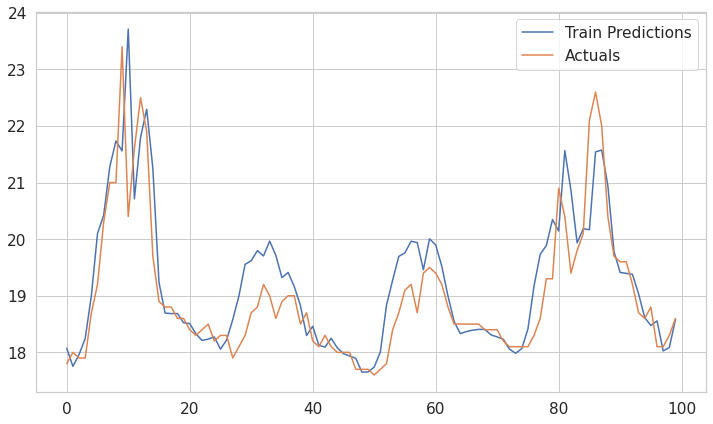




____________________________________________________________________________________________________
                                    LSTM Model - VALIDATION DATA                                    


MAPE: 3.23%


      Val Predictions  Actuals
0           20.246611     19.6
1           20.623640     22.2
2           22.989832     24.2
3           24.627693     24.8
4           24.818012     23.4
...               ...      ...
8761        23.397524     24.0
8762        24.699736     22.8
8763        23.218491     21.6
8764        21.996695     24.6
8765        24.713291     24.5

[8766 rows x 2 columns]


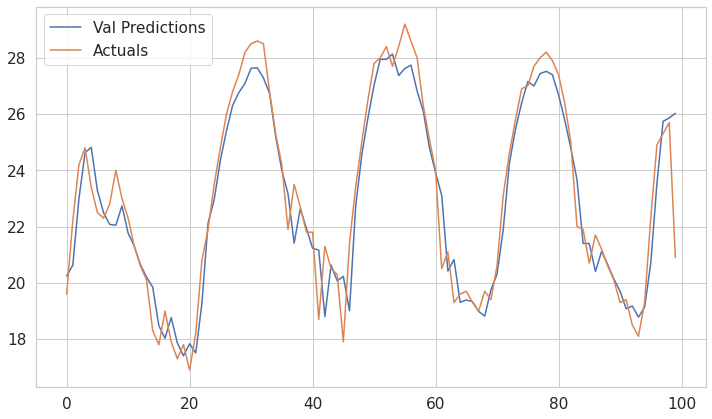




____________________________________________________________________________________________________
                                       LSTM Model - TEST DATA                                       


MAPE: 3.2%


      Test Predictions  Actuals
0            24.301878     20.0
1            20.070337     22.3
2            21.770128     23.9
3            22.728350     23.9
4            22.499660     21.7
...                ...      ...
8761         27.470903     28.1
8762         26.912823     23.6
8763         22.695259     23.6
8764         22.577753     22.3
8765         21.468582     21.3

[8766 rows x 2 columns]


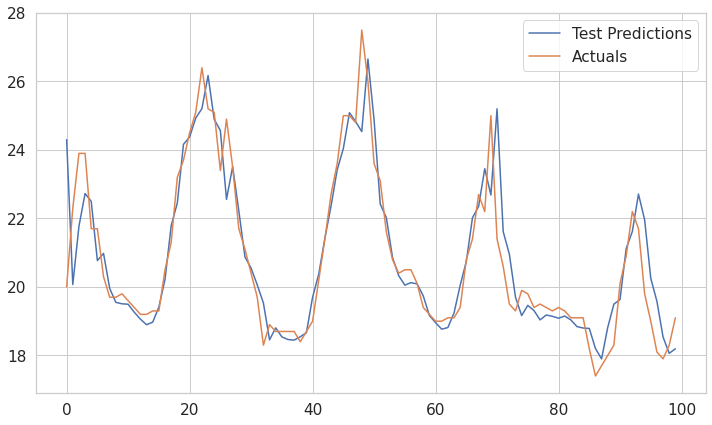

In [26]:
show_model(model_LSTM_cyclic, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, model_name='LSTM')

### Model - GRU
---

In [27]:
%%time
model_GRU_cyclic = train_model_GRU(X2_train, y2_train, X2_val, y2_val, 'model_GRU_cyclic', epochs=10, learning_rate=0.0001, input_layer=(6,5))

Epoch 1/10
2192/2192 [==============================] - 14s 6ms/step - loss: 75.7747 - root_mean_squared_error: 8.7049 - mean_absolute_percentage_error: 23.9987 - val_loss: 2.0854 - val_root_mean_squared_error: 1.4441 - val_mean_absolute_percentage_error: 4.4160


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 2/10
2192/2192 [==============================] - 21s 10ms/step - loss: 1.1871 - root_mean_squared_error: 1.0896 - mean_absolute_percentage_error: 3.5287 - val_loss: 1.2168 - val_root_mean_squared_error: 1.1031 - val_mean_absolute_percentage_error: 3.5429


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 3/10
2192/2192 [==============================] - 17s 8ms/step - loss: 0.9825 - root_mean_squared_error: 0.9912 - mean_absolute_percentage_error: 3.2637 - val_loss: 1.1179 - val_root_mean_squared_error: 1.0573 - val_mean_absolute_percentage_error: 3.3860


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 4/10
2192/2192 [==============================] - 12s 5ms/step - loss: 0.9522 - root_mean_squared_error: 0.9758 - mean_absolute_percentage_error: 3.2151 - val_loss: 1.0940 - val_root_mean_squared_error: 1.0459 - val_mean_absolute_percentage_error: 3.3538


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 5/10
2192/2192 [==============================] - 12s 5ms/step - loss: 0.9336 - root_mean_squared_error: 0.9662 - mean_absolute_percentage_error: 3.1710 - val_loss: 1.0795 - val_root_mean_squared_error: 1.0390 - val_mean_absolute_percentage_error: 3.3127


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 6/10
2192/2192 [==============================] - 12s 5ms/step - loss: 0.9210 - root_mean_squared_error: 0.9597 - mean_absolute_percentage_error: 3.1379 - val_loss: 1.0628 - val_root_mean_squared_error: 1.0309 - val_mean_absolute_percentage_error: 3.3255


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 7/10
2192/2192 [==============================] - 13s 6ms/step - loss: 0.9119 - root_mean_squared_error: 0.9550 - mean_absolute_percentage_error: 3.1236 - val_loss: 1.0538 - val_root_mean_squared_error: 1.0266 - val_mean_absolute_percentage_error: 3.2456


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 8/10
2192/2192 [==============================] - 12s 5ms/step - loss: 0.9069 - root_mean_squared_error: 0.9523 - mean_absolute_percentage_error: 3.1070 - val_loss: 1.0477 - val_root_mean_squared_error: 1.0235 - val_mean_absolute_percentage_error: 3.2833


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 9/10
2192/2192 [==============================] - 13s 6ms/step - loss: 0.9025 - root_mean_squared_error: 0.9500 - mean_absolute_percentage_error: 3.1011 - val_loss: 1.0516 - val_root_mean_squared_error: 1.0255 - val_mean_absolute_percentage_error: 3.2802
Epoch 10/10
2192/2192 [==============================] - 12s 6ms/step - loss: 0.8999 - root_mean_squared_error: 0.9486 - mean_absolute_percentage_error: 3.0973 - val_loss: 1.0378 - val_root_mean_squared_error: 1.0187 - val_mean_absolute_percentage_error: 3.2325


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


____________________________________________________________________________________________________
                                             GRU Model                                              



____________________________________________________________________________________________________
                                       GRU Model - TRAIN DATA                                       


MAPE: 3.07%


       Train Predictions  Actuals
0              18.136826     17.8
1              17.839312     18.0
2              18.146093     17.9
3              18.310984     17.9
4              18.698231     18.7
...                  ...      ...
70129          18.146029     18.2
70130          18.283968     18.4
70131          18.744608     18.0
70132          18.754555     18.7
70133          19.862743     19.0

[70134 rows x 2 columns]


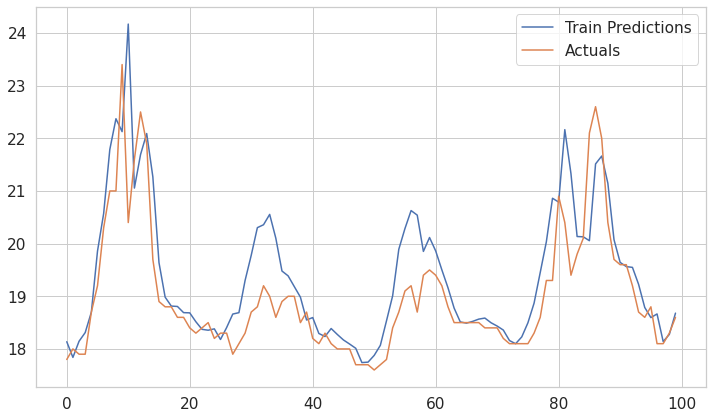




____________________________________________________________________________________________________
                                    GRU Model - VALIDATION DATA                                     


MAPE: 3.23%


      Val Predictions  Actuals
0           20.386591     19.6
1           21.103519     22.2
2           23.646042     24.2
3           25.170172     24.8
4           25.322489     23.4
...               ...      ...
8761        23.803814     24.0
8762        25.126051     22.8
8763        23.712767     21.6
8764        22.288015     24.6
8765        24.953287     24.5

[8766 rows x 2 columns]


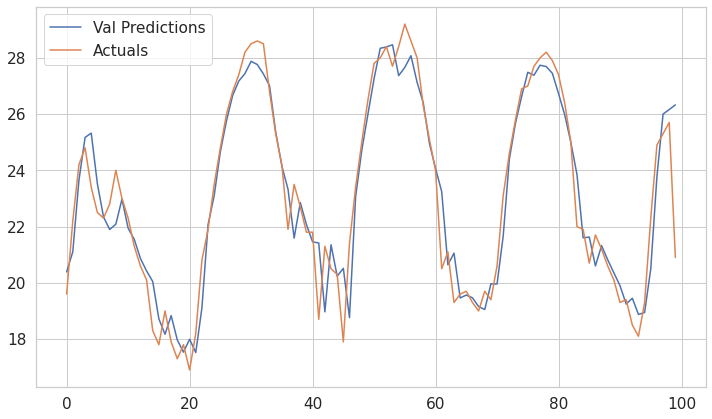




____________________________________________________________________________________________________
                                       GRU Model - TEST DATA                                        


MAPE: 3.23%


      Test Predictions  Actuals
0            24.303799     20.0
1            20.362141     22.3
2            21.868803     23.9
3            22.902634     23.9
4            22.694788     21.7
...                ...      ...
8761         27.311518     28.1
8762         26.955317     23.6
8763         22.824953     23.6
8764         22.839476     22.3
8765         21.642679     21.3

[8766 rows x 2 columns]


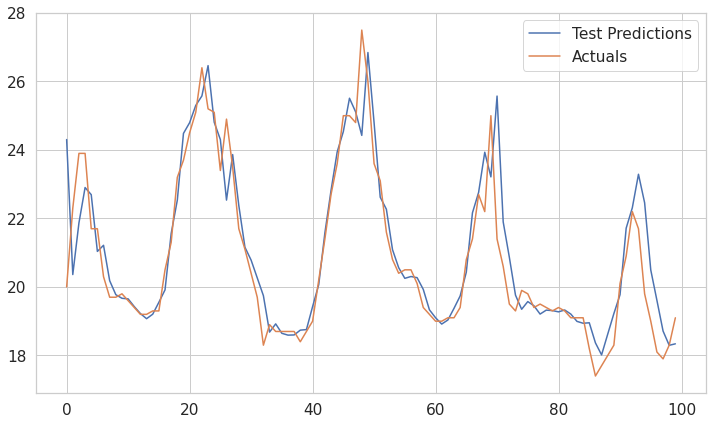

In [28]:
show_model(model_GRU_cyclic, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, model_name='GRU')

### Model - Conv1d
---

In [38]:
%%time
model_conv1d_cyclic = train_model_conv1d(X2_train, y2_train, X2_val, y2_val, 'model_conv1d_cyclic', epochs=10, learning_rate=0.0001, input_layer=(6,5))

Epoch 1/10
2192/2192 [==============================] - 8s 3ms/step - loss: 24.2589 - root_mean_squared_error: 4.9253 - mean_absolute_percentage_error: 12.5381 - val_loss: 2.1892 - val_root_mean_squared_error: 1.4796 - val_mean_absolute_percentage_error: 5.4180
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 2/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.6608 - root_mean_squared_error: 1.2887 - mean_absolute_percentage_error: 4.7758 - val_loss: 1.5465 - val_root_mean_squared_error: 1.2436 - val_mean_absolute_percentage_error: 4.4276
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 3/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.2290 - root_mean_squared_error: 1.1086 - mean_absolute_percentage_error: 3.9335 - val_loss: 1.2735 - val_root_mean_squared_error: 1.1285 - val_mean_absolute_percentage_error: 3.8378
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 4/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.1096 - root_mean_squared_error: 1.0534 - mean_absolute_percentage_error: 3.6195 - val_loss: 1.2424 - val_root_mean_squared_error: 1.1146 - val_mean_absolute_percentage_error: 3.6662
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 5/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.0877 - root_mean_squared_error: 1.0429 - mean_absolute_percentage_error: 3.5463 - val_loss: 1.2406 - val_root_mean_squared_error: 1.1138 - val_mean_absolute_percentage_error: 3.7322
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 6/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.0828 - root_mean_squared_error: 1.0406 - mean_absolute_percentage_error: 3.5272 - val_loss: 1.2117 - val_root_mean_squared_error: 1.1008 - val_mean_absolute_percentage_error: 3.6184
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 7/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.0785 - root_mean_squared_error: 1.0385 - mean_absolute_percentage_error: 3.5201 - val_loss: 1.2090 - val_root_mean_squared_error: 1.0996 - val_mean_absolute_percentage_error: 3.6114
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 8/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.0751 - root_mean_squared_error: 1.0369 - mean_absolute_percentage_error: 3.5051 - val_loss: 1.2085 - val_root_mean_squared_error: 1.0993 - val_mean_absolute_percentage_error: 3.6355
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 9/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.0745 - root_mean_squared_error: 1.0366 - mean_absolute_percentage_error: 3.5148 - val_loss: 1.2322 - val_root_mean_squared_error: 1.1100 - val_mean_absolute_percentage_error: 3.6467
Epoch 10/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.0725 - root_mean_squared_error: 1.0356 - mean_absolute_percentage_error: 3.5049 - val_loss: 1.2194 - val_root_mean_squared_error: 1.1043 - val_mean_absolute_percentage_error: 3.6198
CPU times: user 55.3 s, sys: 4.04 s, total: 59.4 s
Wall time: 49.6 s


____________________________________________________________________________________________________
                                            Conv1d Model                                            



____________________________________________________________________________________________________
                                     Conv1d Model - TRAIN DATA                                      


MAPE: 3.26%


       Train Predictions  Actuals
0              18.019548     17.8
1              17.923334     18.0
2              18.191717     17.9
3              18.268049     17.9
4              18.605883     18.7
...                  ...      ...
70129          18.112724     18.2
70130          18.314972     18.4
70131          18.741381     18.0
70132          18.761961     18.7
70133          19.573549     19.0

[70134 rows x 2 columns]


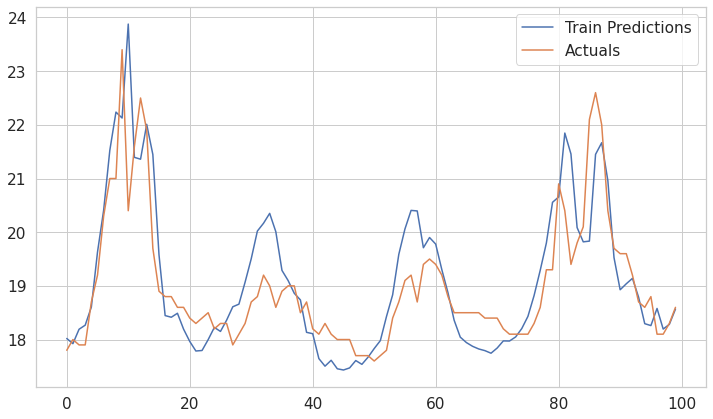




____________________________________________________________________________________________________
                                   Conv1d Model - VALIDATION DATA                                   


MAPE: 3.45%


      Val Predictions  Actuals
0           20.210405     19.6
1           20.873262     22.2
2           23.173885     24.2
3           25.174536     24.8
4           25.662989     23.4
...               ...      ...
8761        23.452280     24.0
8762        25.093760     22.8
8763        24.056597     21.6
8764        22.325884     24.6
8765        24.336542     24.5

[8766 rows x 2 columns]


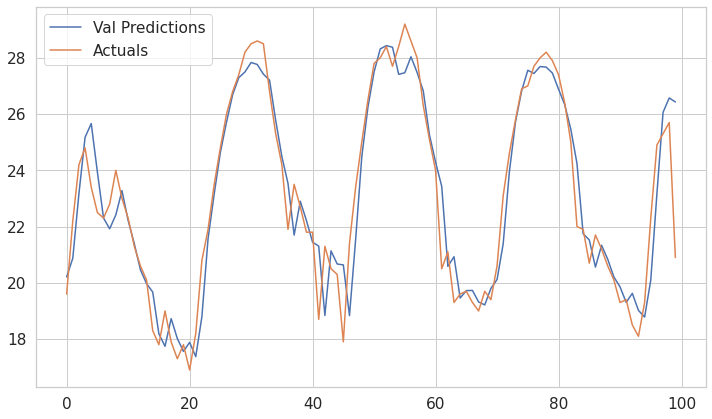




____________________________________________________________________________________________________
                                      Conv1d Model - TEST DATA                                      


MAPE: 3.41%


      Test Predictions  Actuals
0            24.675200     20.0
1            20.371897     22.3
2            21.623045     23.9
3            22.861277     23.9
4            23.207787     21.7
...                ...      ...
8761         27.239233     28.1
8762         26.977858     23.6
8763         23.500834     23.6
8764         23.217276     22.3
8765         21.992928     21.3

[8766 rows x 2 columns]


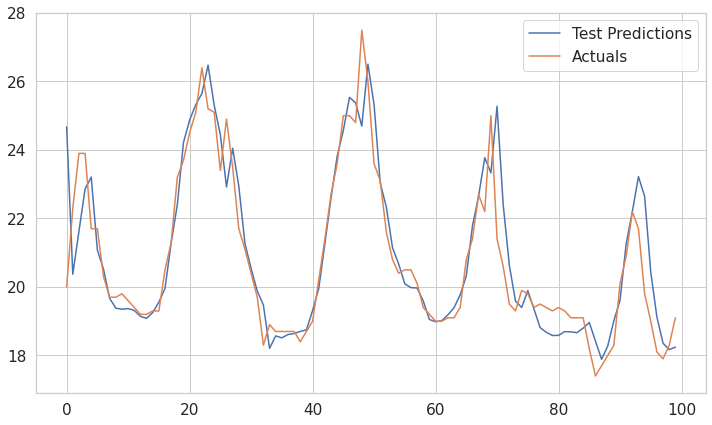

In [37]:
show_model(model_conv1d_cyclic, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, model_name='Conv1d')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Skewness: 0.48
Kurtosis: -0.22


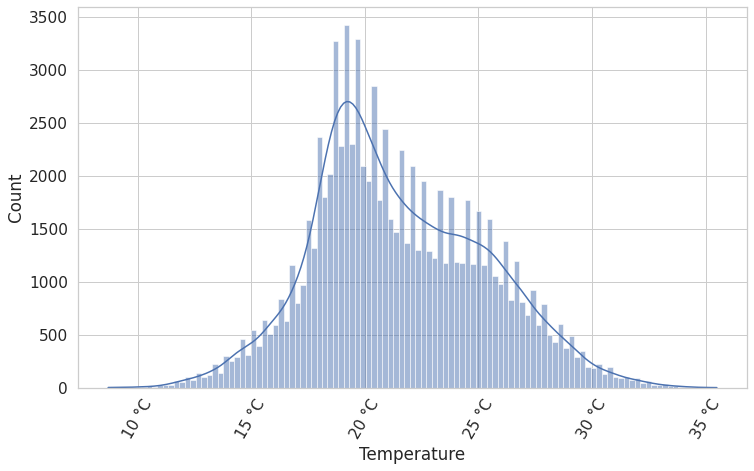

Skewness: 0.22
Kurtosis: 0.0661731291200911


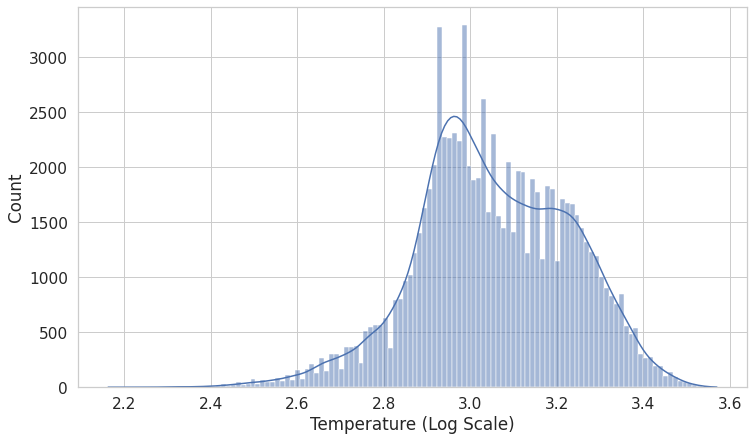

In [33]:
from scipy.stats import kurtosis
from statistics import mean, mode, median
import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor

from matplotlib import ticker

# Calculating coefficient of skewness ( Pearson's second coefficient of skewness )
skewness = (3 * (df['Temperature'].mean() - df['Temperature'].median())) / df['Temperature'].std()

print(f"Skewness: {round(skewness, 2)}")
print(f'Kurtosis: {round(kurtosis(df.Temperature), 2)}')

ax = sns.histplot(data=df, x='Temperature', kde=True)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f} °C'))
plt.xticks(rotation=60)
plt.show()


# Calculating coefficient of skewness with log transformation ( Pearson's second coefficient of skewness )
df_log = np.log(df['Temperature'])
skewness_log = (3 * (df_log.mean() - df_log.median())) / df_log.std()

print(f"Skewness: {round(skewness_log, 2)}")
print(f'Kurtosis: {kurtosis(np.log(df["Temperature"]))}')
sns.histplot(data=df, x=np.log(df["Temperature"]), kde=True)
plt.xlabel('Temperature (Log Scale)')
plt.show()